## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">Libraries</p>

In [89]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">Data</p>

> review.csv.gz
    - 리뷰 comments 분석 함에 있어 관련 데이터 확인

In [51]:
review = pd.read_csv('/Users/genie/Documents/COLLABORATION/AirbnbWise/Tokyo_Airbnb/data/reviews.csv.gz', compression='gzip')
review.head()
#* listing_id을 사용한다.
#! reviews.csv.gz의 listing_id는 nunique는 9925개가 존재한다.
#! listing.csv.gz의  null값을 제거 하면 listing_id의 nunique값이 9925개가 존재한다.

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...


In [52]:
review['listing_id'].nunique()

9925

> listings.csv.gz

In [53]:
#* listings.csv.gz 에서 # id와 리뷰날짜 / 리뷰 평점과 상관계수가 높은 관련 칼럼만 추출
listings = pd.read_csv('/Users/genie/Documents/COLLABORATION/AirbnbWise/Tokyo_Airbnb/data/listings.csv.gz', compression='gzip')
listingR = listings[['id','first_review','last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]
listingR.head(3)

,id,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,197677,2011-09-21,2023-05-30,4.78,4.74,4.92,4.84,4.83,4.53,4.79
1,776070,2012-11-28,2023-06-20,4.98,4.96,4.92,4.98,4.98,4.83,4.91
2,905944,2013-04-07,2023-06-26,4.76,4.78,4.75,4.87,4.90,4.77,4.77


In [54]:
listingR.corr()['review_scores_rating'].sort_values(ascending=False).head(10)

review_scores_rating           1.000000
review_scores_accuracy         0.818054
review_scores_value            0.798197
review_scores_cleanliness      0.784065
review_scores_communication    0.702486
review_scores_checkin          0.638581
review_scores_location         0.577754
id                            -0.024169
Name: review_scores_rating, dtype: float64

In [55]:
listingR_NaN_deleted = listingR.dropna(subset=['review_scores_rating'], how = 'any', axis = 0)

In [56]:
listingR_NaN_deleted.shape

(9925, 10)

In [57]:
listingR_NaN_deleted['id'].nunique()

9925

> listings.csv : 확인해보니 활용할 중요 칼럼 없음(상관계수가 낮음)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">comment EDA</p>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#F1C93B; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #F1C93B">감성 분석 - Logistic Regression</p>

In [58]:
a = review[['listing_id', 'date', 'comments']] 
a.columns = ['id', 'date','comments']
b = listingR_NaN_deleted[['id','first_review', 'review_scores_rating']] 
b.columns = ['id', 'date','review_scores_rating']
comment = pd.merge(a, b, on=['id','date'], how='inner')
comment.head()

,id,date,comments,review_scores_rating
0,197677,2011-09-21,Couldn’t get any better!\r<br/>\r<br/>The apar...,4.78
1,3427384,2014-08-30,"Beautiful clean, cozy and comfortable apartmen...",4.82
2,3514008,2014-12-21,２泊お世話になりました。とても静かな近所でぐっすり眠れましたし、ホストのお二人がいろいろ用意...,4.86
3,3563698,2014-08-16,"Ken's place is really fantastic.""Thank you"" is...",4.87
4,776070,2012-11-28,"One night, better say a few hours was not enou...",4.98


In [59]:
#* 병합된 데이터 정보 맞는지 확인
a[(a['id'] == 776070) & (a['date'] == '2012-11-28')]

,id,date,comments
545,776070,2012-11-28,"One night, better say a few hours was not enou..."


In [60]:
#* 병합된 데이터 정보 맞는지 확인2
b[b['id'] == 776070]

,id,date,review_scores_rating
1,776070,2012-11-28,4.98


In [61]:
comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9996
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9997 non-null   int64  
 1   date                  9997 non-null   object 
 2   comments              9996 non-null   object 
 3   review_scores_rating  9997 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 390.5+ KB


In [62]:
comment[comment['comments'].isnull()] #* 유일한 null값 제거해야 tfidf 적용 가능

,id,date,comments,review_scores_rating
1385,26343528,2018-07-21,NaN,4.95


In [63]:
delindex = comment[comment['comments'].isnull()].index
comment.drop(delindex, inplace=True)

In [64]:
df = comment[['review_scores_rating','comments']]
df.columns = ['rating', 'comments']
df.head()

,rating,comments
0,4.78,Couldn’t get any better!\r<br/>\r<br/>The apar...
1,4.82,"Beautiful clean, cozy and comfortable apartmen..."
2,4.86,２泊お世話になりました。とても静かな近所でぐっすり眠れましたし、ホストのお二人がいろいろ用意...
3,4.87,"Ken's place is really fantastic.""Thank you"" is..."
4,4.98,"One night, better say a few hours was not enou..."


In [65]:
fig = px.histogram(df, x = 'rating')
fig.update_traces(marker_color = 'red', marker_line_width=2, marker_line_color='black', marker_opacity =0.5)
fig.show()

In [66]:
fig2 = px.box(df, x = 'rating')
fig2.show()

In [67]:
def rating_to_label(rating):
    if rating > 4.54: #* 1분위 수 값 
        return 1
    else:
        return 0

df['y'] = df['rating'].apply(lambda x: rating_to_label(x))
df.head()

,rating,comments,y
0,4.78,Couldn’t get any better!\r<br/>\r<br/>The apar...,1
1,4.82,"Beautiful clean, cozy and comfortable apartmen...",1
2,4.86,２泊お世話になりました。とても静かな近所でぐっすり眠れましたし、ホストのお二人がいろいろ用意...,1
3,4.87,"Ken's place is really fantastic.""Thank you"" is...",1
4,4.98,"One night, better say a few hours was not enou...",1


In [68]:
df['y'].value_counts()

1    7457
0    2539
Name: y, dtype: int64

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 번역 우선 안함, tfidf 옵션 테스트

tfv =  TfidfVectorizer(ngram_range = (1, 2), min_df = 4, sublinear_tf=True)
text = tfv.fit_transform(df['comments'])
text

<9996x11792 sparse matrix of type '<class 'numpy.float64'>'
	with 292625 stored elements in Compressed Sparse Row format>

In [76]:
print(text[0]) #* 첫 번째 리뷰에서의 단어 중요도 TF_IDF 값

  (0, 4838)	0.11398885909619774
  (0, 2812)	0.1360493435203124
  (0, 2426)	0.13804917793303034
  (0, 8046)	0.14602935459115352
  (0, 9398)	0.14602935459115352
  (0, 3518)	0.14602935459115352
  (0, 4428)	0.07236445294684714
  (0, 643)	0.1208732382585476
  (0, 8781)	0.09695382453050845
  (0, 3595)	0.06921717955724635
  (0, 4223)	0.14602935459115352
  (0, 5247)	0.11739604044598075
  (0, 3237)	0.11251149569634884
  (0, 10622)	0.14602935459115352
  (0, 10918)	0.10441381705948401
  (0, 9650)	0.10274240619708504
  (0, 837)	0.12249150676718996
  (0, 8357)	0.10659760742291596
  (0, 2371)	0.09385819262201718
  (0, 9452)	0.14602935459115352
  (0, 2173)	0.06525985061725058
  (0, 7255)	0.11939587485869871
  (0, 10681)	0.12854747928537044
  (0, 9978)	0.09499596533858645
  (0, 4801)	0.06491332903555266
  :	:
  (0, 5227)	0.10441381705948401
  (0, 3178)	0.07830052145617679
  (0, 10657)	0.05203789196435299
  (0, 3274)	0.14602935459115352
  (0, 3548)	0.07639879113574878
  (0, 9940)	0.04286844311337517
  

In [77]:
print(tfv.vocabulary_)

{'couldn': 2439, 'get': 3667, 'any': 897, 'better': 1492, 'br': 1599, 'the': 8674, 'apartment': 930, 'itself': 4936, 'is': 4646, 'great': 3805, 'it': 4825, 'has': 3976, 'everything': 3043, 'you': 10864, 'could': 2423, 'need': 6022, 'besides': 1475, 'that': 8628, 'neighborhood': 6062, 'very': 9940, 'friendly': 3548, 'fill': 3274, 'with': 10657, 'family': 3178, 'life': 5227, 'energy': 2890, 'really': 7250, 'close': 2164, 'to': 9253, 'supermarket': 8476, 'some': 8034, 'convenience': 2368, 'stores': 8356, 'and': 469, 'train': 9641, 'stations': 8233, 'will': 10614, 'feel': 3233, 'like': 5243, 'home': 4215, 'from': 3564, 'first': 3296, 'moment': 5822, 'if': 4409, 'forget': 3517, 'pack': 6689, 'something': 8044, 'easily': 2809, 'br br': 1616, 'br the': 1699, 'the apartment': 8691, 'apartment itself': 946, 'itself is': 4937, 'is great': 4712, 'great it': 3833, 'it has': 4866, 'has everything': 3980, 'everything you': 3063, 'you could': 10875, 'could need': 2431, 'need br': 6024, 'br besides': 

In [72]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10)
svd_text = svd.fit_transform(text)
svd_text

array([[ 1.11077219e-01, -1.96099871e-02,  2.20261934e-01, ...,
        -1.37750850e-02, -3.06975406e-03,  2.40672503e-03],
       [ 1.28310495e-01, -2.21722597e-02,  2.42989363e-01, ...,
         5.68787871e-02, -3.30759808e-03,  3.59973257e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.01325908e-03, -2.07567735e-03,  5.13150436e-02, ...,
        -1.00246391e-02, -4.61532490e-04, -1.51013877e-03],
       [ 9.71088126e-02,  9.83612710e-01,  3.58328412e-02, ...,
         1.10279602e-03, -1.16113235e-01,  8.52505526e-02]])

In [74]:
for idx in range(len(svd_text.shape)):
    df[f"svd_text{idx+1}"] = svd_text[:,idx]
df

,rating,comments,y,svd_text1,svd_text2,svd_text3,svd_text4,svd_text5,svd_text6,svd_text7,svd_text8,svd_text9,svd_text10
0,4.78,Couldn’t get any better!\r<br/>\r<br/>The apar...,1,0.111077,-0.019610,2.202619e-01,-0.037718,-0.003336,0.004464,-0.063366,-0.013775,-0.003070,0.002407
1,4.82,"Beautiful clean, cozy and comfortable apartmen...",1,0.128310,-0.022172,2.429894e-01,-0.032160,-0.005096,0.009216,-0.006915,0.056879,-0.003308,0.003600
2,4.86,２泊お世話になりました。とても静かな近所でぐっすり眠れましたし、ホストのお二人がいろいろ用意...,1,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4.87,"Ken's place is really fantastic.""Thank you"" is...",1,0.064463,-0.016991,2.860550e-01,-0.044953,-0.001733,0.000610,-0.014541,0.054275,-0.000843,0.002754
4,4.98,"One night, better say a few hours was not enou...",1,0.053617,-0.013358,2.154761e-01,-0.037801,-0.001100,0.005433,-0.049087,-0.027425,-0.000552,0.001343
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,5.00,位置很好，交通便利，房东热情好客，会再次回来。,1,0.001138,-0.000306,-4.021180e-07,-0.000009,-0.002448,0.000385,0.002473,-0.003198,-0.004438,-0.011924
9993,5.00,新しい一軒家です。<br/>部屋全体綺麗です。<br/>大家さんは優しい人です。<br/>夜...,1,0.825864,0.548694,-9.567514e-03,0.000713,-0.040594,-0.000255,0.001809,-0.000424,-0.096773,0.068740
9994,4.00,とても綺麗な所でした！,0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9995,5.00,Perfect spot in shinokubo.Just as advertised.,1,0.002013,-0.002076,5.131504e-02,-0.010484,0.000643,-0.002512,-0.019516,-0.010025,-0.000462,-0.001510


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">Modeling</p>

In [79]:
from sklearn.model_selection import train_test_split

x = text
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [81]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7996, 11792), (7996,), (2000, 11792), (2000,))

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

# predict in test set
y_pred = lr.predict(X_test)

In [84]:
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.76
precision: 0.76
recall: 1.00
F1: 0.86


In [87]:
lr.coef_

array([[-0.01736568, -0.07327678, -0.23898858, ...,  0.19017499,
         0.10375028, -0.0938799 ]])

<BarContainer object of 11792 artists>

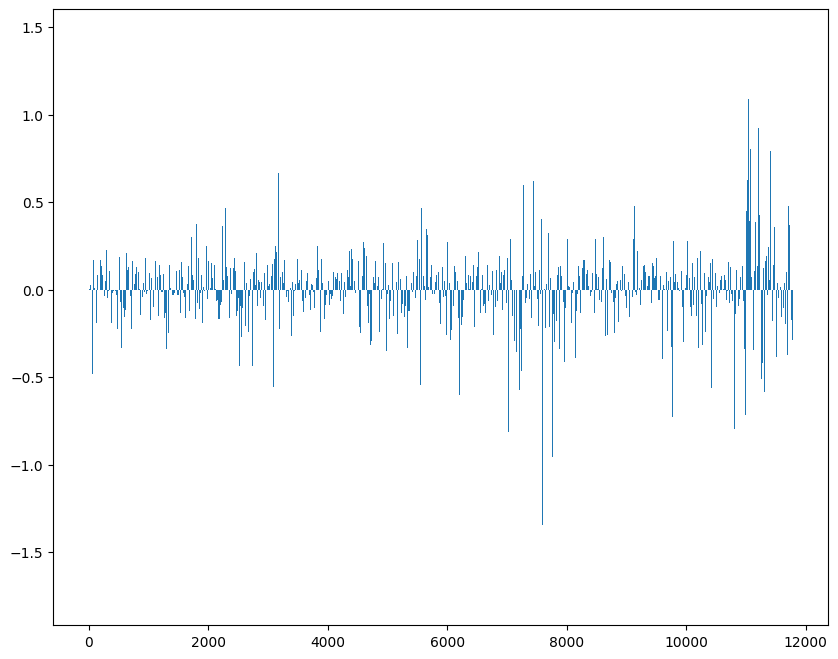

In [90]:
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [92]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)[-5:])

[(1.4413528986503814, 6096), (1.3707006222537683, 11273), (1.2328697610674704, 11050), (1.2238295669117119, 11031), (1.1940276195946744, 2095)]
[(-1.0121860090905321, 11459), (-1.1822291361799038, 11003), (-1.3461634807873508, 7597), (-1.36719672261706, 1811), (-1.757150426332934, 6247)]


In [96]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_pos_index

[(1.4413528986503814, 6096),
 (1.3707006222537683, 11273),
 (1.2328697610674704, 11050),
 (1.2238295669117119, 11031),
 (1.1940276195946744, 2095),
 (1.1798155349077843, 9702),
 (1.1406460854357627, 4357),
 (1.1320434300406172, 4324),
 (1.1140525207228489, 11298),
 (1.106309112037795, 11188),
 (1.1051970819444208, 116),
 (1.0868609007908399, 11045),
 (1.0809854701064363, 11300),
 (1.0695337250909707, 11164),
 (1.0572361561315577, 3840),
 (1.024787621501788, 7720),
 (1.0194414641116305, 4181),
 (0.9921548913204664, 11206),
 (0.9915960164118452, 3108),
 (0.9734914468851545, 5486),
 (0.9646096830991185, 6125),
 (0.9625184603450341, 11274),
 (0.9452540665825327, 1917),
 (0.9405825615931993, 4343),
 (0.9377326162433197, 1616),
 (0.936946133378482, 11213),
 (0.9328403887190391, 11193),
 (0.9315330695762777, 422),
 (0.9244508199519011, 11212),
 (0.8623372638263771, 11098),
 (0.8580327728468381, 11243),
 (0.820916298742426, 10991),
 (0.8175827395954337, 5444),
 (0.8112569137870452, 11030),
 (0

In [97]:
invert_index_vectorizer = {v: k for k, v in tfv.vocabulary_.items()}
invert_index_vectorizer

{2439: 'couldn',
 3667: 'get',
 897: 'any',
 1492: 'better',
 1599: 'br',
 8674: 'the',
 930: 'apartment',
 4936: 'itself',
 4646: 'is',
 3805: 'great',
 4825: 'it',
 3976: 'has',
 3043: 'everything',
 10864: 'you',
 2423: 'could',
 6022: 'need',
 1475: 'besides',
 8628: 'that',
 6062: 'neighborhood',
 9940: 'very',
 3548: 'friendly',
 3274: 'fill',
 10657: 'with',
 3178: 'family',
 5227: 'life',
 2890: 'energy',
 7250: 'really',
 2164: 'close',
 9253: 'to',
 8476: 'supermarket',
 8034: 'some',
 2368: 'convenience',
 8356: 'stores',
 469: 'and',
 9641: 'train',
 8233: 'stations',
 10614: 'will',
 3233: 'feel',
 5243: 'like',
 4215: 'home',
 3564: 'from',
 3296: 'first',
 5822: 'moment',
 4409: 'if',
 3517: 'forget',
 6689: 'pack',
 8044: 'something',
 2809: 'easily',
 1616: 'br br',
 1699: 'br the',
 8691: 'the apartment',
 946: 'apartment itself',
 4937: 'itself is',
 4712: 'is great',
 3833: 'great it',
 4866: 'it has',
 3980: 'has everything',
 3063: 'everything you',
 10875: 'you c

In [98]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

new 1.4413528986503814
设施齐全 1.3707006222537683
また利用させていただきます 1.2328697610674704
とても綺麗で 1.2238295669117119
clean 1.1940276195946744
trip 1.1798155349077843
house is 1.1406460854357627
hotel 1.1320434300406172
非常感谢 1.1140525207228489
房东人很好 1.106309112037795
absolutely 1.1051970819444208
また 1.0868609007908399
非常方便 1.0809854701064363
很干净 1.0695337250909707
great place 1.0572361561315577
she 1.024787621501788
highly 1.0194414641116305
房间干净 0.9921548913204664
experience 0.9915960164118452
lovely 0.9734914468851545


In [99]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

new 1.4413528986503814
设施齐全 1.3707006222537683
また利用させていただきます 1.2328697610674704
とても綺麗で 1.2238295669117119
clean 1.1940276195946744
trip 1.1798155349077843
house is 1.1406460854357627
hotel 1.1320434300406172
非常感谢 1.1140525207228489
房东人很好 1.106309112037795
absolutely 1.1051970819444208
また 1.0868609007908399
非常方便 1.0809854701064363
很干净 1.0695337250909707
great place 1.0572361561315577
she 1.024787621501788
highly 1.0194414641116305
房间干净 0.9921548913204664
experience 0.9915960164118452
lovely 0.9734914468851545
